# Package

In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning import loggers
from pytorch_lightning.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

# Environment config

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"

def format_bytes(size):
    # 2**10 = 1024
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'kilo', 2: 'mega', 3: 'giga', 4: 'tera'}
    while size > power:
        size /= power
        n += 1
    return "%.2f" % size, power_labels[n] + 'bytes'

torch.cuda.get_device_name(), format_bytes(torch.cuda.get_device_properties(device).total_memory)

('GeForce GTX 1080 Ti', ('10.92', 'gigabytes'))

# Load data

In [53]:
from preprocessing.load_sup_dataset import load_train_test

In [54]:
trainset, valset = load_train_test(augmentation = 1)



>> Loading the trainset
Total images are 93408




>> Loading the testset
Total images are 98904




In [67]:
batch_size = 84
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 4)
valloader = torch.utils.data.DataLoader(valset, batch_size = batch_size, num_workers = 4)
len(trainloader), len(valloader)

(1112, 1178)

torch.Size([84, 3, 224, 224]) torch.Size([84])


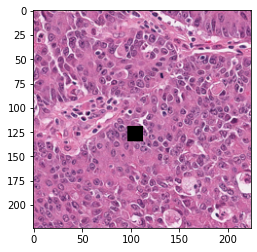

In [61]:
images, labels = next(iter(trainloader))

print(images.shape, labels.shape)
def imshow(img):
    inp = img.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    # plt.show()

imshow(images[0])

# Massive Attention model

In [70]:
from trainer.supervised.massiveattention_trainer import MassiveAttentionTrainer

run_on = "CRC_DX"

In [71]:
massiveattention_trainer = MassiveAttentionTrainer(trainloader, valloader, num_cycle = 8, valset = valset, netname = "resnet50_se",
                                                  reduce_backbone = None)
max_epochs = massiveattention_trainer.get_max_epochs()

In [72]:
checkpoint_path = os.path.join(os.getcwd(), "checkpoint", run_on, "massive_attention")
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_top_k = -1,
    verbose = True,
    monitor = 'val_loss',
    mode = 'min'
)

checkpoint_path

'/home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention'

In [73]:
tb_logger = loggers.TensorBoardLogger('logs/' + run_on, name = "massiveattention")
trainer = pl.Trainer(checkpoint_callback = checkpoint_callback,
                     nb_sanity_val_steps=0, 
                     max_epochs = max_epochs, 
                     gpus = -1, 
                    logger = tb_logger
                    )

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


# Learning rate finder

In [74]:
lr_finder = trainer.lr_find(massiveattention_trainer)

INFO:lightning:
    | Name                                                        | Type               | Params
-----------------------------------------------------------------------------------------------
0   | criterion                                                   | BCEWithLogitsLoss  | 0     
1   | model                                                       | MassiveAttention   | 31 M  
2   | model.backbone                                              | Sequential         | 26 M  
3   | model.backbone.0                                            | Conv2d             | 9 K   
4   | model.backbone.1                                            | BatchNorm2d        | 128   
5   | model.backbone.2                                            | ReLU               | 0     
6   | model.backbone.3                                            | MaxPool2d          | 0     
7   | model.backbone.4                                            | Sequential         | 240 K 
8   | model.backbone.4.0

>> Reset the optimizer


INFO:lightning:LR finder stopped early due to diverging loss.


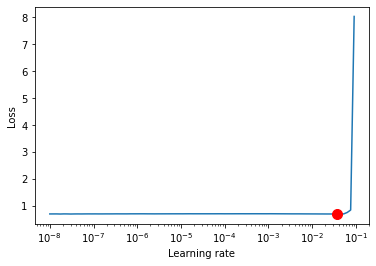

In [75]:
fig = lr_finder.plot(suggest = True)

In [76]:
massiveattention_trainer.base_lr = 8e-5
massiveattention_trainer.max_lr = 1e-2
massiveattention_trainer.configure_optimizers()

>> Reset the optimizer


SGD (
Parameter Group 0
    base_momentum: 0.85
    dampening: 0
    initial_lr: 0.0004
    lr: 0.0003999999999999993
    max_lr: 0.01
    max_momentum: 0.95
    min_lr: 4e-08
    momentum: 0.95
    nesterov: False
    weight_decay: 1e-05
)

# Start to train the model

In [77]:
trainer.fit(massiveattention_trainer)

INFO:lightning:
    | Name                                                        | Type               | Params
-----------------------------------------------------------------------------------------------
0   | criterion                                                   | BCEWithLogitsLoss  | 0     
1   | model                                                       | MassiveAttention   | 31 M  
2   | model.backbone                                              | Sequential         | 26 M  
3   | model.backbone.0                                            | Conv2d             | 9 K   
4   | model.backbone.1                                            | BatchNorm2d        | 128   
5   | model.backbone.2                                            | ReLU               | 0     
6   | model.backbone.3                                            | MaxPool2d          | 0     
7   | model.backbone.4                                            | Sequential         | 240 K 
8   | model.backbone.4.0

>> Reset the optimizer


INFO:lightning:
Epoch 00001: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=1_v1.ckpt


INFO:lightning:
Epoch 00002: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=2_v1.ckpt


INFO:lightning:
Epoch 00003: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=3_v1.ckpt


INFO:lightning:
Epoch 00004: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=4_v1.ckpt


INFO:lightning:
Epoch 00005: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=5_v1.ckpt


INFO:lightning:
Epoch 00006: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=6_v1.ckpt


INFO:lightning:
Epoch 00007: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=7_v1.ckpt


INFO:lightning:
Epoch 00008: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=8_v1.ckpt


INFO:lightning:
Epoch 00009: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=9_v1.ckpt


INFO:lightning:
Epoch 00010: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=10_v1.ckpt


INFO:lightning:
Epoch 00011: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=11_v1.ckpt


INFO:lightning:
Epoch 00012: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=12_v1.ckpt


INFO:lightning:
Epoch 00013: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=13_v1.ckpt


INFO:lightning:
Epoch 00014: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=14_v1.ckpt


INFO:lightning:
Epoch 00015: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=15_v1.ckpt


INFO:lightning:
Epoch 00016: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=16_v1.ckpt


INFO:lightning:
Epoch 00017: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=17_v1.ckpt


INFO:lightning:
Epoch 00018: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=18_v1.ckpt


INFO:lightning:
Epoch 00019: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=19_v1.ckpt


INFO:lightning:
Epoch 00020: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=20_v1.ckpt


INFO:lightning:
Epoch 00021: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=21_v1.ckpt


INFO:lightning:
Epoch 00022: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=22_v1.ckpt


INFO:lightning:
Epoch 00023: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=23_v1.ckpt


INFO:lightning:
Epoch 00024: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=24_v1.ckpt


INFO:lightning:
Epoch 00025: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=25_v1.ckpt


INFO:lightning:
Epoch 00026: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=26_v1.ckpt


INFO:lightning:
Epoch 00027: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=27_v1.ckpt


INFO:lightning:
Epoch 00028: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=28_v1.ckpt


INFO:lightning:
Epoch 00029: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=29_v1.ckpt


INFO:lightning:
Epoch 00030: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=30_v1.ckpt


INFO:lightning:
Epoch 00031: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=31_v1.ckpt


1

# Evaluate the model

## Run test set

In [ ]:
from evaluate.evaluator import Evaluator
from trainer.massiveattention_trainer import MassiveAttentionTrainer

checkpoint_path = ["checkpoint/eval/massiveattention/full/_ckpt_epoch_{}.ckpt".format(x) for x in range(19, 20)]
evaluator = Evaluator(MassiveAttentionTrainer, "Massive Attention", checkpoint_path, trainloader, valloader, valset, "logs/eval/massiveattention/version1/")

In [ ]:
evaluator.run_validation()

## Run on noise set

In [ ]:
evaluator.batch_size = batch_size
evaluator.run_test_set()

## Calibrating graph

In [ ]:
evaluator.calibrater.n_bins = 30
evaluator.calibrated_graph("verions1")

In [ ]:
evaluator.calibrater.n_bins = 5
evaluator.calibrated_graph("verions2")

In [ ]:
evaluator.calibrater.n_bins = 15
evaluator.calibrated_graph("verions3")